<a href="https://colab.research.google.com/github/TheS1n233/Distributed-Learning-Project5/blob/experiments/centralized_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
!pip install --upgrade torch

## Imports

In [30]:
import torch
import argparse
from torch.optim.optimizer import Optimizer, required
import torch
import torchvision
import torchvision.transforms as transforms
import random
import numpy as np
import json
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, SequentialLR, LinearLR
import matplotlib.pyplot as plt
import copy
import time
from torch.amp import GradScaler, autocast
import os
from google.colab import drive
from torch.utils.data import DataLoader, random_split
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.optim.lr_scheduler")
drive.mount('/content/drive')
if not os.path.exists('/content/drive/MyDrive'):
    raise RuntimeError("Google Drive not mounted correctly!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Costants

In [31]:
NUM_EPOCHS = 150
BATCH_SIZE = 64
OPTIMIZER = 'SGDM' # Choose: 'SGDM', 'AdamW'
SAVE_PATH= f"/content/drive/My Drive/Colab Notebooks/Traning_summary/{OPTIMIZER}"
CHECKPOINT_NAME = f"checkpoint_{OPTIMIZER}_last.pth"
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if OPTIMIZER == 'SGDM':
    try:
      with open('/content/drive/MyDrive/best_hyperparams_SGDM.json', 'r') as f:
          best_hyperparams = json.load(f)
    except FileNotFoundError:
      best_hyperparams = {
          'lr': 0.01  ,
          'weight_decay': 0.001,
          'momentum': 0.9,
      }

elif OPTIMIZER == 'AdamW':

    try:
      with open('/content/drive/MyDrive/best_hyperparams_AdamW.json', 'r') as f:
          best_hyperparams = json.load(f)
    except FileNotFoundError:
      best_hyperparams = {
          'lr':  0.001,
          'weight_decay': 0.1,
      }

else:
    raise ValueError("Invalid optimizer type")


## Model

In [32]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=5)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=5)

        self.fc1 = nn.Linear(64 * 5 * 5, 384)
        self.fc2 = nn.Linear(384, 192)
        self.fc3 = nn.Linear(192, 100)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)

        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)

        return x

## Function to get train, test and val dataset

In [33]:
def calulcate_mean_std(batch_size=100, verbose=True):
    # Transform only for caluclate meaning of the dataset
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    # Load the CIFAR-100 training dataset
    train_dataset = torchvision.datasets.CIFAR100(
        root='./data',
        train=True,
        download=True,
        transform=transform
    )


    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=False, num_workers=0)

    # Initialize sums for calculating mean and std
    mean = torch.zeros(3)
    std = torch.zeros(3)

    for images, _ in train_loader:
        # Compute mean and std for each channel
        mean += images.mean(dim=[0, 2, 3])
        std += images.std(dim=[0, 2, 3])

    mean /= len(train_loader)
    std /= len(train_loader)

    if verbose:
      print("Mean: ", mean)
      print("Std: ", std)

    return mean, std

In [34]:
def get_dataset(batch_size, verbose=False):

    print("Start loading data with batch_size", batch_size)

    mean, std = calulcate_mean_std()

    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[mean[0].item(), mean[1].item(), mean[2].item()],
                            std=[std[0].item(), std[1].item(), std[2].item()])
    ])

    transform_test = transforms.Compose([
        transforms.CenterCrop(32),
        transforms.ToTensor(),
        transforms.Normalize(mean=[mean[0].item(), mean[1].item(), mean[2].item()],
                            std=[std[0].item(), std[1].item(), std[2].item()])
    ])

    # Load CIFAR-100 dataset
    start_time = time.time()
    train_dataset = torchvision.datasets.CIFAR100(
        root='./data',
        train=True,
        download=True,
        transform=transform_train
    )
    test_dataset = torchvision.datasets.CIFAR100(
        root='./data',
        train=False,
        download=True,
        transform=transform_test
    )

    if verbose:
        print(f"Dataset loading time: {time.time() - start_time:.2f} seconds")

    # Split training and validation sets
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

    # Data loaders
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        pin_memory=True
    )

    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )

    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )

    # Debugging: Check DataLoader outputs
    if verbose:
        for i, (inputs, labels) in enumerate(train_loader):

            print(f"Batch {i}: inputs shape: {inputs.shape}, labels shape: {labels.shape}")
            if i == 10:  # Test first 10 batches
                break
        print(f"Data loading for 10 batches completed.")

    return train_dataset, train_loader, val_loader, test_loader

In [35]:
class CheckpointSaver:

  def __init__(self, best_hyperparams, epochs, path=SAVE_PATH, checkpoint_name=CHECKPOINT_NAME, optimizer=OPTIMIZER):
    self.path = path
    self.best_hyperparams = best_hyperparams
    self.epochs = epochs
    self.optimizer = optimizer
    self.checkpoint_name = checkpoint_name
    self.create_files()

  def create_files(self):
    os.makedirs(self.path, exist_ok=True)

    self.metrics_files = {
        'train_acc': os.path.join(self.path, f'{self.optimizer}_train_accuracy.txt'),
        'val_acc': os.path.join(self.path, f'{self.optimizer}_val_accuracy.txt'),
        'train_loss': os.path.join(self.path, f'{self.optimizer}_train_loss.txt'),
        'val_loss': os.path.join(self.path, f'{self.optimizer}_val_loss.txt')
    }

    with open(os.path.join(self.path, f'{self.optimizer}_experiment_config.txt'), 'w') as f:
        f.write(f"Experiment Configuration:\n")
        f.write(f"Optimizer: {self.optimizer}\n")
        f.write(f"Hyperparameters: {str(self.best_hyperparams)}\n")
        f.write(f"Number of epochs: {self.epochs}\n")


  def save_checkpoint(self, epoch, train_acc, val_acc, train_loss, val_loss):
      try:
          with open(self.metrics_files['train_acc'], 'a') as f:
              f.write(f"{epoch+1},{train_acc * 100:.2f}%\n")
          with open(self.metrics_files['val_acc'], 'a') as f:
              f.write(f"{epoch+1},{val_acc * 100:.2f}%\n")
          with open(self.metrics_files['train_loss'], 'a') as f:
              f.write(f"{epoch+1},{train_loss:.4f}\n")
          with open(self.metrics_files['val_loss'], 'a') as f:
              f.write(f"{epoch+1},{val_loss:.4f}\n")
      except Exception as e:
          print(f"Error saving metrics: {e}")

  def save_model_checkpoint(self, model, optimizer, epoch):
    checkpoint_path = os.path.join(self.path, self.checkpoint_name)
    try:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, checkpoint_path)
    except Exception as e:
        print(f"Error saving model checkpoint: {e}")

  def load_model_checkpoint(self, model, optimizer):
    try:
        checkpoint = torch.load(self.path + self.checkpoint_name)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        print(f"Checkpoint loaded successfully. Resuming from epoch {start_epoch}")
        return start_epoch
    except Exception as e:
        print(f"Error loading model checkpoint: {e}")
        return 0

  def delete_checkpoint(self):
      final_path = self.path
      if os.path.exists(final_path):
            for file_name in os.listdir(final_path):
                file_path = os.path.join(final_path, file_name)
                if os.path.isfile(file_path):
                    os.remove(file_path)
            print(f"All existing checkpoints in {final_path} have been deleted.")
      else:
            print(f"No checkpoint folder found at {final_path}.")


## Centralized baseline training function

In [36]:
def train_model_with_hyperparams(train_loader, val_loader, test_loader, best_hyperparams, num_epochs, device, type_of_optimizer=OPTIMIZER, verbose=False):
    # Initialize the LeNet5 model and move it to the specified device (e.g., GPU or CPU).
    model = LeNet5().to(device)

    # Configure the optimizer based on the specified type and hyperparameters.
    if type_of_optimizer == "SGDM":
        # Ensure required hyperparameters for SGD with momentum are provided.
        if best_hyperparams.get('momentum', None) is None:
            raise ValueError("Momentum is required for SGDM")
        if best_hyperparams.get('weight_decay', None) is None:
            raise ValueError("Weight decay is required for SGDM")
        if best_hyperparams.get('lr', None) is None:
            raise ValueError("Learning rate is required for SGDM")

        # Initialize SGD optimizer with momentum.
        optimizer = optim.SGD(
            model.parameters(),
            lr=best_hyperparams['lr'],
            weight_decay=best_hyperparams['weight_decay'],
            momentum=best_hyperparams['momentum'],
        )

    elif type_of_optimizer == "AdamW":
        # Ensure required hyperparameters for AdamW are provided.
        if best_hyperparams.get('lr', None) is None:
            raise ValueError("Learning rate is required for AdamW")
        if best_hyperparams.get('weight_decay', None) is None:
            raise ValueError("Weight decay is required for AdamW")

        # Initialize AdamW optimizer.
        optimizer = optim.AdamW(
            model.parameters(),
            lr=best_hyperparams['lr'],
            weight_decay=best_hyperparams['weight_decay'],
        )

    else:
        raise ValueError("Invalid optimizer type")

    print(f"Train running with {type_of_optimizer} optimizer.")

    # Define learning rate scheduler and loss function.
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)  # Cosine annealing schedule for LR.
    criterion = nn.CrossEntropyLoss()

    # Initialize the checkpoint saver to save and restore training states.
    cs = CheckpointSaver(
        best_hyperparams=best_hyperparams,
        epochs=num_epochs
    )

    # Check for existing training checkpoints.
    start_epoch = 0
    if os.path.exists(SAVE_PATH + CHECKPOINT_NAME):
        start_epoch = cs.load_model_checkpoint(model, optimizer)  # Restore model and optimizer state.
        print(f"Recover, from {start_epoch} epoch to train")
    else:
        print("Start training from beginning")

    # Initialize metrics for tracking loss and accuracy.
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

    # Training loop over epochs.
    for epoch in range(start_epoch, num_epochs):
        model.train()  # Set model to training mode.
        train_loss_total, train_correct, train_total = 0, 0, 0
        last_lr = optimizer.param_groups[0]['lr']  # Current learning rate.

        if verbose:
            print(f"Epoch {epoch}: before Learning Rate = {last_lr:.6f}")

        # Training step: iterate over the training dataset.
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            optimizer.zero_grad()  # Clear previous gradients.

            outputs = model(inputs)  # Forward pass.
            loss = criterion(outputs, labels)  # Compute loss.
            loss.backward()  # Backward pass (compute gradients).
            optimizer.step()  # Update model parameters.

            # Update training metrics.
            train_loss_total += loss.item()
            _, predicted = outputs.max(1)  # Get predicted class.
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()

        # Calculate average training loss and accuracy for the epoch.
        train_loss = train_loss_total / len(train_loader)
        train_acc = 100. * train_correct / train_total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validate the model on the validation set.
        val_acc, val_loss = val_model(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # Print learning rate and metrics for the epoch.
        last_lr = optimizer.param_groups[0]['lr']

        if verbose:
            print(f"Epoch {epoch}: after Learning Rate = {last_lr:.6f}")

        # Save training state and model checkpoint.
        cs.save_checkpoint(epoch, train_acc, val_acc, train_loss, val_loss)
        cs.save_model_checkpoint(model, optimizer, epoch)

        # Log epoch results.
        print(f"Epoch {epoch + 1}/{num_epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        scheduler.step()  # Update learning rate.

    # Evaluate the final model on the test set.
    test_acc = 100 * test_model(model, test_loader, device)
    print(f"Final Test Accuracy: {test_acc:.2f}%")

    # Remove saved checkpoints after training is complete.
    cs.delete_checkpoint()

    return train_losses, val_losses, train_accuracies, val_accuracies, test_acc


def val_model(model, val_loader, criterion, device):
    # Validation loop to calculate loss and accuracy.
    model.eval()  # Set model to evaluation mode.
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():  # Disable gradient computation for validation.
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)  # Get predicted class.
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_loader)  # Average validation loss.
    val_acc = correct / total  # Validation accuracy.
    return val_acc * 100, val_loss


def test_model(model, test_loader, device):
    # Test loop to calculate accuracy on the test dataset.
    model.eval()  # Set model to evaluation mode.
    correct, total = 0, 0
    with torch.no_grad():  # Disable gradient computation for testing.
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)  # Get predicted class.
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    test_acc = correct / total
    return test_acc


def plot_results(train_losses, val_losses, train_accuracies, val_accuracies, save_path=SAVE_PATH):
    # Plot and save training and validation metrics (loss and accuracy)
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"{save_path}/training_results.png")  # Save the plot
    print(f"Training results saved to {save_path}")
    plt.show()


## Main

Start loading data with batch_size 64
Files already downloaded and verified
Mean:  tensor([0.5071, 0.4865, 0.4409])
Std:  tensor([0.2667, 0.2558, 0.2754])
Files already downloaded and verified
Files already downloaded and verified

Using Best Hyperparameters from Grid Search: {'lr': 0.01, 'weight_decay': 0.001, 'momentum': 0.9}
Train running with SGDM optimizer.
Start training from beginning
Epoch 1/10 | Train Loss: 4.1686, Train Acc: 6.18% | Val Loss: 3.8527, Val Acc: 10.09%
Epoch 2/10 | Train Loss: 3.6674, Train Acc: 13.46% | Val Loss: 3.5391, Val Acc: 15.60%
Epoch 3/10 | Train Loss: 3.3562, Train Acc: 18.76% | Val Loss: 3.2862, Val Acc: 19.73%
Epoch 4/10 | Train Loss: 3.1220, Train Acc: 22.80% | Val Loss: 3.1011, Val Acc: 23.18%
Epoch 5/10 | Train Loss: 2.9300, Train Acc: 26.68% | Val Loss: 2.9130, Val Acc: 27.18%
Epoch 6/10 | Train Loss: 2.7336, Train Acc: 30.65% | Val Loss: 2.8401, Val Acc: 28.69%
Epoch 7/10 | Train Loss: 2.5705, Train Acc: 33.85% | Val Loss: 2.6716, Val Acc: 31.9

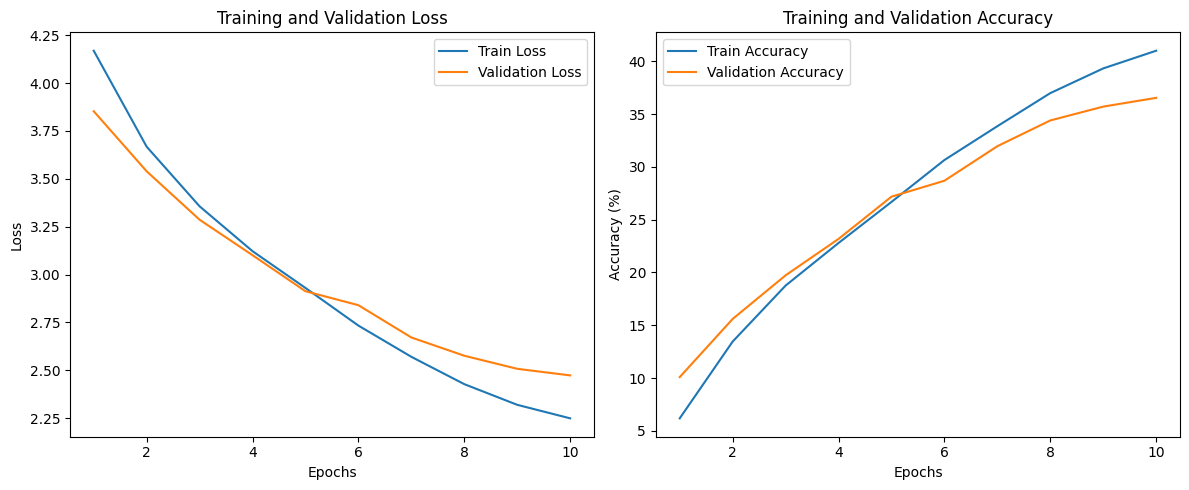

In [37]:
if __name__ == "__main__":

    train_dataset, train_loader, val_loader, test_loader = get_dataset(BATCH_SIZE)

    print("\nUsing Best Hyperparameters from Grid Search:", best_hyperparams)

    # Train with the best hyperparameters from girdsearch
    train_losses, val_losses, train_accuracies, val_accuracies, test_acc = train_model_with_hyperparams(
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        best_hyperparams=best_hyperparams,
        num_epochs=NUM_EPOCHS,
        device=DEVICE,
    )
    plot_results(train_losses, val_losses, train_accuracies, val_accuracies)
